In [4]:
import ezc3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# 1. Load the C3D file
c3d_path = 'CVIP\\Project\\data\\C3D\\Calibration.c3d'  # Make sure this file is in your folder
c = ezc3d.c3d(c3d_path)

# Extract data
# points shape is (4, n_markers, n_frames). 4 components are (x, y, z, 1)
point_data = c['data']['points']
labels = c['parameters']['POINT']['LABELS']['value']

# Helper function to get (x, y, z) for a specific marker at a specific frame
def get_marker_pos(name, frame_idx):
    try:
        idx = labels.index(name)
        # return x, y, z
        return point_data[0:3, idx, frame_idx]
    except ValueError:
        return None

# 2. Define the Skeleton Structure (Bone Connections)
# This maps the marker names in your file to a stick-figure structure.
skeleton_bones = [
    # Head
    ('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD'),
    # Torso / Spine
    ('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10'),
    ('CLAV', 'LSHO'), ('CLAV', 'RSHO'),
    # Left Arm
    ('LSHO', 'LUPA'), ('LUPA', 'LELB'), ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN'),
    # Right Arm
    ('RSHO', 'RUPA'), ('RUPA', 'RELB'), ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN'),
    # Pelvis
    ('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI'),
    # Left Leg (connecting Hip to Knee to Ankle)
    ('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE'),
    # Right Leg
    ('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')
]

# 3. Visualize a specific frame
frame_to_show = 0 

# Arrays for the "Dots" (Markers)
x_nodes, y_nodes, z_nodes = [], [], []
marker_names = []

# Plot all markers as dots
for i, label in enumerate(labels):
    pos = point_data[0:3, i, frame_to_show]
    # Check if point is not empty/zero (sometimes unused markers are 0)
    if not np.all(pos == 0) and not np.isnan(pos).any():
        # ax.scatter(pos[0], pos[1], pos[2], c='red', s=10)
        x_nodes.append(pos[0])
        y_nodes.append(pos[1])
        z_nodes.append(pos[2])
        marker_names.append(label)


# Arrays for the "Lines" (Bones)
# Plotly draws a single continuous line, so we insert 'None' to break the line between bones
x_lines, y_lines, z_lines = [], [], []

# Plot the "Bones" as lines
for marker1, marker2 in skeleton_bones:
    pos1 = get_marker_pos(marker1, frame_to_show)
    pos2 = get_marker_pos(marker2, frame_to_show)
    
    if pos1 is not None and pos2 is not None:
        # Check validity again
        if not np.isnan(pos1).any() and not np.isnan(pos2).any():
            # ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], c='blue')
            x_lines.extend([pos1[0], pos2[0], None])
            y_lines.extend([pos1[1], pos2[1], None])
            z_lines.extend([pos1[2], pos2[2], None])

fig = go.Figure()

# Add Nodes (Markers)
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=4, color='red'),
    text=marker_names,
    name='Markers',
    hovertemplate='<b>%{text}</b>'
))


# Add Edges (Bones)
fig.add_trace(go.Scatter3d(
    x=x_lines, y=y_lines, z=z_lines,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Skeleton',
    hoverinfo='skip'
))

# Update layout for aspect ratio and labels
fig.update_layout(
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)',
        zaxis_title='Z (mm)',
        aspectmode='data' # This keeps the skeleton proportions correct!
    ),
    title=f"Interactive Skeleton (Frame {frame_to_show})"
)

fig.show()

In [1]:
import ezc3d
import numpy as np
import plotly.graph_objects as go

# 1. Load Data
c = ezc3d.c3d('CVIP\\Project\\data\\C3D\\Calibration.c3d')
point_data = c['data']['points']
labels = c['parameters']['POINT']['LABELS']['value']

# Helper to find marker index
def get_pos(name, frame):
    try:
        idx = labels.index(name)
        return point_data[0:3, idx, frame] 
    except ValueError:
        return None

# 2. Define Groups (Colors and Markers)
body_config = {
    'Head': {
        'color': '#9b59b6', # Purple
        'markers': ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'LMAS', 'RMAS', 'GLAB'],
        'bones': [('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD')]
    },
    'Torso': {
        'color': '#2ecc71', # Green
        'markers': ['C7', 'T2', 'T10', 'CLAV', 'STRN', 'RBAK'],
        'bones': [('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10')]
    },
    'Pelvis': {
        'color': '#f1c40f', # Yellow
        'markers': ['LASI', 'RASI', 'LPSI', 'RPSI'],
        'bones': [('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI')]
    },
    'Left Arm': {
        'color': '#e74c3c', # Red
        'markers': ['LSHO', 'LUPA', 'LELB', 'LFRM', 'LWRA', 'LWRB', 'LFIN'],
        'bones': [('CLAV', 'LSHO'), ('LSHO', 'LUPA'), ('LUPA', 'LELB'), 
                  ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN')]
    },
    'Right Arm': {
        'color': '#3498db', # Blue
        'markers': ['RSHO', 'RUPA', 'RELB', 'RFRM', 'RWRA', 'RWRB', 'RFIN'],
        'bones': [('CLAV', 'RSHO'), ('RSHO', 'RUPA'), ('RUPA', 'RELB'), 
                  ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN')]
    },
    'Left Leg': {
        'color': '#e67e22', # Orange
        'markers': ['LTHI', 'LKNE', 'LTIB', 'LANK', 'LTOE', 'LHEE'],
        'bones': [('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE')]
    },
    'Right Leg': {
        'color': '#1abc9c', # Teal
        'markers': ['RTHI', 'RKNE', 'RTIB', 'RANK', 'RTOE', 'RHEE'],
        'bones': [('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')]
    }
}

# 3. Create the Figure
fig = go.Figure()
frame = 0 

# Keep track of which markers we have plotted to handle "Others" later
plotted_markers = set()

# Iterate through each body part to create separate traces
for part_name, config in body_config.items():
    color = config['color']
    
    # --- A. Prepare Markers for this part ---
    x_nodes, y_nodes, z_nodes, names = [], [], [], []
    for m_name in config['markers']:
        pos = get_pos(m_name, frame)
        if pos is not None and not np.isnan(pos).any() and not np.all(pos == 0):
            x_nodes.append(pos[0])
            y_nodes.append(pos[1])
            z_nodes.append(pos[2])
            names.append(m_name)
            plotted_markers.add(m_name)

    # Add Marker Trace
    fig.add_trace(go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers',
        marker=dict(size=5, color=color),
        text=names,
        hovertemplate='<b>%{text}</b> (' + part_name + ')',
        name=f'{part_name} Markers'
    ))

    # --- B. Prepare Bones for this part ---
    x_lines, y_lines, z_lines = [], [], []
    for m1, m2 in config['bones']:
        p1 = get_pos(m1, frame)
        p2 = get_pos(m2, frame)
        if p1 is not None and p2 is not None and not np.isnan(p1).any():
            x_lines.extend([p1[0], p2[0], None])
            y_lines.extend([p1[1], p2[1], None])
            z_lines.extend([p1[2], p2[2], None])

    # Add Bone Trace
    fig.add_trace(go.Scatter3d(
        x=x_lines, y=y_lines, z=z_lines,
        mode='lines',
        line=dict(color=color, width=3),
        name=f'{part_name} Bones',
        hoverinfo='skip'
    ))

# 4. Handle "Other" Markers (undefined in groups)
x_misc, y_misc, z_misc, misc_names = [], [], [], []
for i, label in enumerate(labels):
    if label not in plotted_markers:
        pos = point_data[0:3, i, frame]
        if not np.all(pos == 0) and not np.isnan(pos).any():
            x_misc.append(pos[0])
            y_misc.append(pos[1])
            z_misc.append(pos[2])
            misc_names.append(label)

# if x_misc:
#     fig.add_trace(go.Scatter3d(
#         x=x_misc, y=y_misc, z=z_misc,
#         mode='markers',
#         marker=dict(size=3, color='grey', opacity=0.5),
#         text=misc_names,
#         hovertemplate='<b>%{text}</b> (Other)',
#         name='Other Markers'
#     ))

# 5. Final Layout
fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="Color-Coded Skeleton Structure",
    legend=dict(itemsizing='constant')
)

fig.show()

In [6]:
import ezc3d
import numpy as np
import plotly.graph_objects as go

# --- 1. SETTINGS ---
filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d' 

# --- 2. LOAD DATA ---
try:
    c = ezc3d.c3d(filename)
    point_data = c['data']['points']
    # Clean labels (strip spaces) and ensure they are strings
    labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
    print(f"SUCCESS: Loaded {filename}")
    print(f"Total Markers: {len(labels)}")
    
except Exception as e:
    print(f"Error loading file: {e}")
    point_data = None
    labels = []

# --- 3. DEFINE SKELETON ---
# The code will look for these standard names in your file's label list
body_config = {
    'Head': {
        'color': '#9b59b6', 
        'markers': ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'LMAS', 'RMAS', 'GLAB'],
        'bones': [('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD')]
    },
    'Torso': {
        'color': '#2ecc71',
        'markers': ['C7', 'T2', 'T10', 'CLAV', 'STRN', 'RBAK'],
        'bones': [('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10')]
    },
    'Pelvis': {
        'color': '#f1c40f',
        'markers': ['LASI', 'RASI', 'LPSI', 'RPSI'],
        'bones': [('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI')]
    },
    'Left Arm': {
        'color': '#e74c3c',
        'markers': ['LSHO', 'LUPA', 'LELB', 'LFRM', 'LWRA', 'LWRB', 'LFIN'],
        'bones': [('CLAV', 'LSHO'), ('LSHO', 'LUPA'), ('LUPA', 'LELB'), 
                  ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN')]
    },
    'Right Arm': {
        'color': '#3498db',
        'markers': ['RSHO', 'RUPA', 'RELB', 'RFRM', 'RWRA', 'RWRB', 'RFIN'],
        'bones': [('CLAV', 'RSHO'), ('RSHO', 'RUPA'), ('RUPA', 'RELB'), 
                  ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN')]
    },
    'Left Leg': {
        'color': '#e67e22',
        'markers': ['LTHI', 'LKNE', 'LTIB', 'LANK', 'LTOE', 'LHEE'],
        'bones': [('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE')]
    },
    'Right Leg': {
        'color': '#1abc9c',
        'markers': ['RTHI', 'RKNE', 'RTIB', 'RANK', 'RTOE', 'RHEE'],
        'bones': [('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')]
    }
}

# --- 4. ROBUST START FRAME DETECTION ---
if point_data is not None:
    start_frame = 0
    total_frames = point_data.shape[2]
    found_start = False
    
    print("Scanning for valid data...")
    
    # Check every 5th frame
    for f in range(0, total_frames, 5):
        valid_count = 0
        for i in range(point_data.shape[1]):
            val_x = point_data[0, i, f]
            # STRICT CHECK: Must be non-zero AND non-NaN
            if val_x != 0 and not np.isnan(val_x):
                valid_count += 1
        
        # If we see more than 15 valid markers, assume subject is here
        if valid_count > 15:
            start_frame = f
            found_start = True
            print(f"Subject detected at Frame {start_frame} ({valid_count} markers visible)")
            break
    
    if not found_start:
        print("WARNING: Could not find any frame with >15 valid markers. Showing Frame 0 anyway.")

    # --- 5. GENERATE ANIMATION ---
    frames = []
    step = 5
    # Show 300 frames (approx 3-5 seconds depending on Hz)
    stop_frame = min(start_frame + 300, total_frames)
    layout_frames = list(range(start_frame, stop_frame, step))

    # Helper: Get XYZ
    def get_pos(name, f_idx):
        if name in labels:
            idx = labels.index(name)
            return point_data[0:3, idx, f_idx]
        return None

    print(f"Generating animation frames {start_frame} to {stop_frame}...")
    
    for f in layout_frames:
        frame_data = []
        for part, config in body_config.items():
            # A. Markers
            x_n, y_n, z_n = [], [], []
            for m in config['markers']:
                pos = get_pos(m, f)
                if pos is not None and not np.isnan(pos).any() and not np.all(pos==0):
                    x_n.append(pos[0]); y_n.append(pos[1]); z_n.append(pos[2])
            
            frame_data.append(go.Scatter3d(
                x=x_n, y=y_n, z=z_n, mode='markers',
                marker=dict(size=4, color=config['color']),
                hoverinfo='skip'
            ))

            # B. Bones
            x_l, y_l, z_l = [], [], []
            for m1, m2 in config['bones']:
                p1 = get_pos(m1, f)
                p2 = get_pos(m2, f)
                # Check BOTH points are valid before drawing line
                if (p1 is not None and p2 is not None and 
                    not np.isnan(p1).any() and not np.isnan(p2).any() and
                    not np.all(p1==0) and not np.all(p2==0)):
                    
                    x_l.extend([p1[0], p2[0], None])
                    y_l.extend([p1[1], p2[1], None])
                    z_l.extend([p1[2], p2[2], None])
            
            frame_data.append(go.Scatter3d(
                x=x_l, y=y_l, z=z_l, mode='lines',
                line=dict(color=config['color'], width=3),
                hoverinfo='skip'
            ))
        frames.append(go.Frame(data=frame_data, name=str(f)))

    # --- 6. DISPLAY ---
    fig = go.Figure(data=frames[0].data, frames=frames)
    
    # Calculate Camera Box using the Start Frame
    all_p = point_data[0:3, :, start_frame]
    # Filter for valid X, Y, Z
    mask = (all_p[0,:] != 0) & (~np.isnan(all_p[0,:]))
    valid_p = all_p[:, mask]

    if valid_p.shape[1] > 0:
        mid_x = np.mean(valid_p[0, :])
        mid_y = np.mean(valid_p[1, :])
        mid_z = np.mean(valid_p[2, :])
        
        box = 1200 # mm radius
        
        fig.update_layout(
            title="Running Skeleton",
            scene=dict(
                xaxis=dict(range=[mid_x-box, mid_x+box], title='X'),
                yaxis=dict(range=[mid_y-box, mid_y+box], title='Y'),
                zaxis=dict(range=[0, 2200], title='Z'), # Height usually 0 to 2m
                aspectmode='cube'
            ),
            updatemenus=[{'type': 'buttons', 'buttons': [
                {'label': 'Play', 'method': 'animate', 'args': [None, dict(frame=dict(duration=30, redraw=True), fromcurrent=True)]},
                {'label': 'Pause', 'method': 'animate', 'args': [[None], dict(frame=dict(duration=0, redraw=False), mode='immediate')]}
            ]}],
            sliders=[{'steps': [dict(method='animate', args=[[str(f)], dict(mode='immediate', frame=dict(duration=0, redraw=True))], label=str(f)) for f in layout_frames]}]
        )
        fig.show()
    else:
        print("CRITICAL ERROR: No valid points found at start frame to center the camera.")
        print("Start Frame was:", start_frame)
        print("This means the file might be entirely empty or corrupted.")

<>:6: SyntaxWarning:

invalid escape sequence '\P'

<>:6: SyntaxWarning:

invalid escape sequence '\P'

C:\Users\Admin\AppData\Local\Temp\ipykernel_15272\3963948718.py:6: SyntaxWarning:

invalid escape sequence '\P'



SUCCESS: Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d
Total Markers: 206
Scanning for valid data...
Subject detected at Frame 4305 (196 markers visible)
Generating animation frames 4305 to 4605...


<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Admin\AppData\Local\Temp\ipykernel_12856\48654576.py:9: SyntaxWarning: invalid escape sequence '\P'
  filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d'


Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d (100.0 Hz). Found 206 markers.
Auto-detected Floor Height: 311.6 mm
Steps Detected -> Left: 79, Right: 79


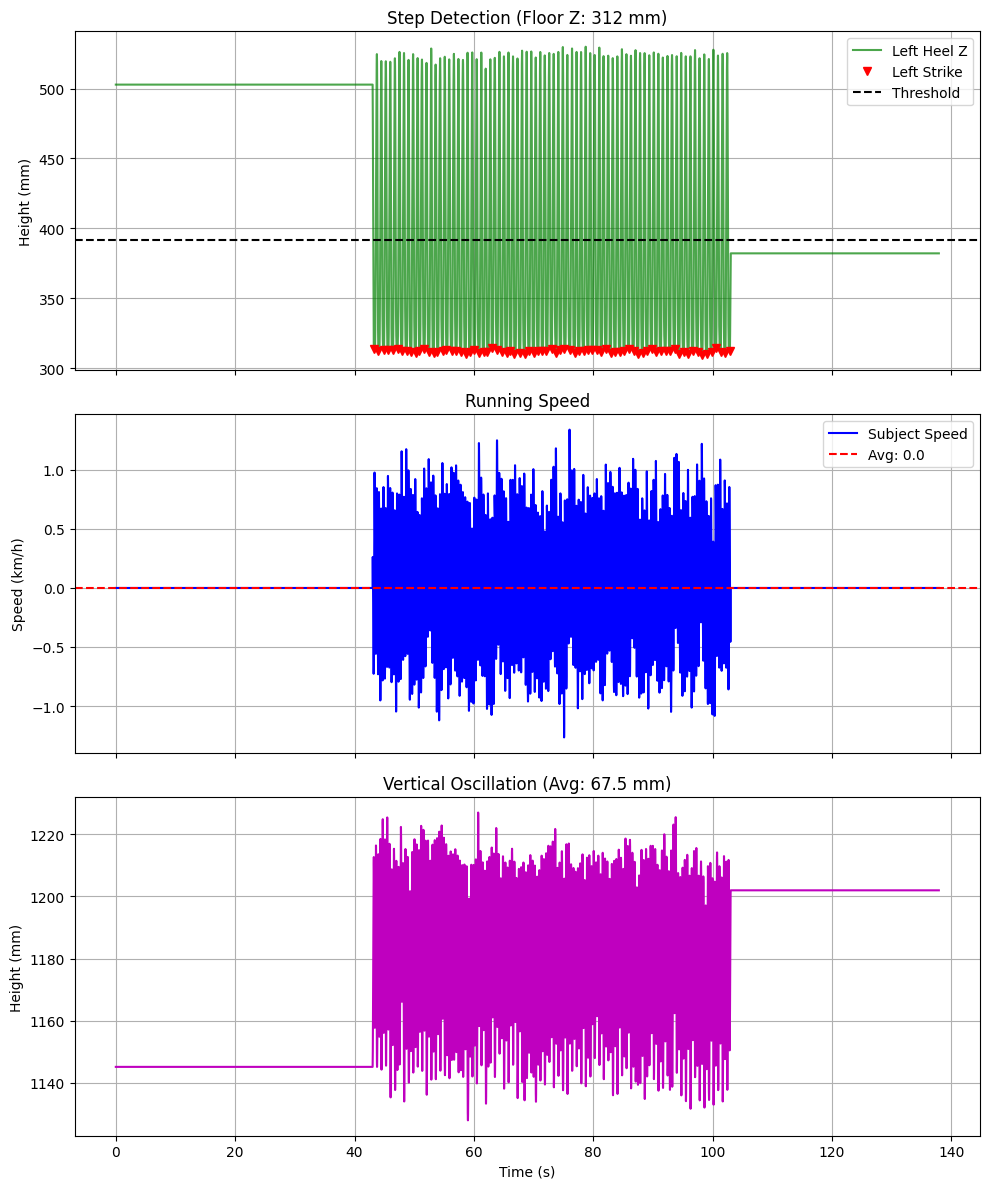


   RUNNING ANALYSIS REPORT
           Metric      Value
        Avg Speed  0.00 km/h
        Max Speed  0.73 km/h
        Min Speed -0.71 km/h
          Cadence   68.7 spm
    Stride Length     0.00 m
Vert. Oscillation    67.5 mm


In [4]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# --- 1. CONFIGURATION ---
filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d'

# --- 2. LOAD DATA ---
try:
    c = ezc3d.c3d(filename)
    points = c['data']['points']
    # Clean labels: strip spaces to ensure ' LHEE' matches 'LHEE'
    labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
    rate = c['parameters']['POINT']['RATE']['value'][0]
    print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
except Exception as e:
    print(f"Error loading file: {e}")
    points = None

# --- 3. HELPER FUNCTIONS ---
def get_marker_data(target_names):
    """Finds marker data, handling missing names and NaNs."""
    if isinstance(target_names, str): target_names = [target_names]
    
    # Find indices
    indices = []
    for name in target_names:
        if name in labels:
            indices.append(labels.index(name))
    
    if not indices:
        print(f"Warning: Markers {target_names} not found in file.")
        return None

    # Get Data (Average if multiple markers, e.g. Pelvis)
    data = np.mean(points[0:3, indices, :], axis=1)
    
    # Fix Zeros (often used as missing value) -> Set to NaN
    data[data == 0] = np.nan
    
    # Interpolate small gaps (up to 10 frames)
    for axis in range(3):
        y = data[axis, :]
        nans, x = np.isnan(y), lambda z: z.nonzero()[0]
        if nans.any() and (~nans).any(): # If we have some data but some gaps
            # Use linear interpolation
            y[nans] = np.interp(x(nans), x(~nans), y[~nans])
            data[axis, :] = y
            
    return data

# --- 4. DATA EXTRACTION ---
# Standard marker names (Heel, Toe, Pelvis)
heel_l = get_marker_data(['LHEE', 'L.Heel'])
heel_r = get_marker_data(['RHEE', 'R.Heel'])
pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS'])

if heel_l is None or pelvis is None:
    print("CRITICAL ERROR: Essential markers (Heel/Pelvis) missing. Cannot analyze.")
else:
    # --- 5. DETECT HEEL STRIKES (Robust Method) ---
    # Z-axis is usually vertical (Index 2). Y is forward (Index 1).
    z_idx, y_idx = 2, 1
    
    # Auto-detect floor height (Lowest 1% of heel data)
    floor_z = np.nanpercentile(heel_l[z_idx, :], 1)
    print(f"Auto-detected Floor Height: {floor_z:.1f} mm")
    
    # Threshold: Anything within 50mm of the floor is "Stance"
    # Find peaks in the INVERTED Z signal (Valleys in real Z)
    # Distance = 0.25s (allows Max Cadence ~240 spm)
    min_dist = int(rate * 0.25) 
    
    # Find Left Steps
    hs_l, _ = find_peaks(-heel_l[z_idx, :], height=-(floor_z + 80), distance=min_dist)
    # Find Right Steps
    hs_r, _ = find_peaks(-heel_r[z_idx, :], height=-(floor_z + 80), distance=min_dist)
    
    print(f"Steps Detected -> Left: {len(hs_l)}, Right: {len(hs_r)}")

    if len(hs_l) < 2 or len(hs_r) < 2:
        print("Not enough steps detected to calculate speed. Check the graph below.")
    else:
        # --- 6. CALCULATE BIOMECHANICS ---
        
        # A. Cadence
        duration_min = points.shape[2] / rate / 60
        cadence = (len(hs_l) + len(hs_r)) / duration_min
        
        # B. Speed (Treadmill Belt Speed)
        # We calculate the backward velocity of the foot during stance
        def get_belt_speed(h_data, strikes):
            speeds = []
            vel_y = np.gradient(h_data[y_idx, :], 1/rate)
            for hs in strikes:
                # Look at 5 frames after heel strike (Mid-Stance)
                if hs + 10 < h_data.shape[1]:
                    # Velocity should be negative (moving backwards)
                    v = np.median(vel_y[hs:hs+10])
                    if v < 0: speeds.append(abs(v))
            return np.median(speeds) if speeds else 0

        belt_speed_mm_s = get_belt_speed(heel_l, hs_l)
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
        # C. Instantaneous Speed (Subject Speed)
        # Speed = Belt Speed + Pelvis Velocity (surges forward/back)
        pelvis_vel_y = np.gradient(pelvis[y_idx, :], 1/rate) # mm/s
        subject_speed_mm_s = belt_speed_mm_s + pelvis_vel_y
        subject_speed_kph = (subject_speed_mm_s / 1000) * 3.6
        
        # D. Stride Length
        # Distance covered per gait cycle
        # Cycle Time (s)
        cycle_time_l = np.mean(np.diff(hs_l)) / rate
        stride_len_m = (subject_speed_mm_s.mean() / 1000) * cycle_time_l
        
        # E. Vertical Oscillation
        # Range of Pelvis Z per step
        oscillations = []
        all_hs = np.sort(np.concatenate((hs_l, hs_r)))
        for i in range(len(all_hs)-1):
            segment = pelvis[z_idx, all_hs[i]:all_hs[i+1]]
            if len(segment) > 0:
                oscillations.append(np.max(segment) - np.min(segment))
        vert_osc_mm = np.mean(oscillations)

        # --- 7. PLOTTING ---
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
        
        t = np.arange(points.shape[2]) / rate
        
        # Plot 1: Step Detection (Verification)
        axs[0].plot(t, heel_l[z_idx, :], 'g-', label='Left Heel Z', alpha=0.7)
        axs[0].plot(t[hs_l], heel_l[z_idx, hs_l], 'rv', label='Left Strike')
        axs[0].axhline(floor_z + 80, color='k', linestyle='--', label='Threshold')
        axs[0].set_title(f'Step Detection (Floor Z: {floor_z:.0f} mm)')
        axs[0].set_ylabel('Height (mm)')
        axs[0].legend(loc='upper right')
        axs[0].grid(True)
        
        # Plot 2: Speed Profile
        axs[1].plot(t, subject_speed_kph, 'b-', label='Subject Speed')
        axs[1].axhline(avg_speed_kph, color='r', linestyle='--', label=f'Avg: {avg_speed_kph:.1f}')
        axs[1].set_title('Running Speed')
        axs[1].set_ylabel('Speed (km/h)')
        axs[1].legend()
        axs[1].grid(True)

        # Plot 3: Vertical Oscillation
        axs[2].plot(t, pelvis[z_idx, :], 'm-', label='Pelvis Height')
        axs[2].set_title(f'Vertical Oscillation (Avg: {vert_osc_mm:.1f} mm)')
        axs[2].set_ylabel('Height (mm)')
        axs[2].set_xlabel('Time (s)')
        axs[2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # --- 8. PRINT REPORT ---
        report = pd.DataFrame({
            'Metric': ['Avg Speed', 'Max Speed', 'Min Speed', 'Cadence', 'Stride Length', 'Vert. Oscillation'],
            'Value': [
                f"{avg_speed_kph:.2f} km/h",
                f"{np.percentile(subject_speed_kph, 95):.2f} km/h", # 95th percentile to ignore noise
                f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
                f"{cadence:.1f} spm",
                f"{stride_len_m:.2f} m",
                f"{vert_osc_mm:.1f} mm"
            ]
        })
        print("\n" + "="*30)
        print("   RUNNING ANALYSIS REPORT")
        print("="*30)
        print(report.to_string(index=False))

In [ ]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 1. SETTINGS ---
filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d'

# --- 2. LOAD DATA ---
try:
    c = ezc3d.c3d(filename)
    points = c['data']['points']
    labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
    rate = c['parameters']['POINT']['RATE']['value'][0]
    print(f"Loaded {filename} ({rate} Hz).")
except Exception as e:
    print(f"Error loading file: {e}")
    points = None

# --- 3. HELPER: GET DATA ---
def get_marker(target_names):
    indices = [labels.index(n) for n in target_names if n in labels]
    if not indices: return None
    data = np.mean(points[0:3, indices, :], axis=1) # Shape (3, N)
    data[data == 0] = np.nan # Treat 0 as missing
    return data

# Extract Heel (Primary for speed) and Pelvis (for flight time/oscillation)
heel_l = get_marker(['LHEE', 'L.Heel'])
heel_r = get_marker(['RHEE', 'R.Heel'])
pelvis = get_marker(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS'])

if heel_l is None:
    print("Error: Could not find Heel markers (LHEE/RHEE).")
else:
    # --- 4. AUTO-DETECT AXES ---
    # We calculate the range of motion (Max - Min) for X, Y, Z
    # - Vertical axis (Gravity) has ~100-200mm range (Step height)
    # - Forward axis (Running) has ~1000mm+ range (Stride length)
    # - Lateral axis (Sway) has small range
    
    ranges = np.nanmax(heel_l, axis=1) - np.nanmin(heel_l, axis=1)
    
    # Sort indices by range size
    sorted_axes = np.argsort(ranges)
    
    # Assumption: 
    # Largest Range = Forward/Backward (Running Direction)
    # Medium Range = Vertical (Step Height)
    # Smallest Range = Lateral (Side to side)
    
    fwd_axis = sorted_axes[2] # Max range
    vert_axis = sorted_axes[1] # Medium range
    lat_axis = sorted_axes[0] # Min range
    
    axis_names = {0: 'X', 1: 'Y', 2: 'Z'}
    print(f"Auto-Detected Axes:")
    print(f" -> Forward (Running): {axis_names[fwd_axis]} (Range: {ranges[fwd_axis]:.0f} mm)")
    print(f" -> Vertical (Height): {axis_names[vert_axis]} (Range: {ranges[vert_axis]:.0f} mm)")
    
    # --- 5. CALCULATE TRUE BELT SPEED ---
    # We differentiate Position to get Velocity
    # V = dX / dt
    vel_fwd = np.gradient(heel_l[fwd_axis, :], 1/rate) # mm/s
    
    # In treadmill running, the velocity profile has a "flat" section during stance
    # This flat section is the belt speed.
    # We find this by looking at the histogram of velocities.
    
    # Create Histogram
    # We expect a peak around 0 (swing turnaround) and a peak around -BeltSpeed (stance)
    counts, bins = np.histogram(vel_fwd, bins=100)
    
    # Find the two most common velocities
    # (We ignore 0 because that's when the foot stops in the air)
    valid_bins = bins[:-1][(bins[:-1] < -100) | (bins[:-1] > 100)] # Filter near-zero
    valid_counts = counts[(bins[:-1] < -100) | (bins[:-1] > 100)]
    
    if len(valid_counts) > 0:
        peak_idx = np.argmax(valid_counts)
        dominant_vel = valid_bins[peak_idx] # This is likely the belt speed (sign might vary)
    else:
        dominant_vel = 0
        
    belt_speed_mm_s = abs(dominant_vel)
    belt_speed_kph = (belt_speed_mm_s / 1000) * 3.6
    
    print(f"Estimated Belt Speed: {belt_speed_kph:.2f} km/h")
    
    # --- 6. CALCULATE METRICS ---
    
    # A. Stride Length
    # Stride Length = Speed * Stride Time
    # Find Step Events (Heel Strikes)
    # Use Vertical Axis (inverted) to find ground contacts
    z_inv = -heel_l[vert_axis, :]
    min_dist = int(rate * 0.4) # Min 0.4s between steps
    hs_l, _ = find_peaks(z_inv, distance=min_dist)
    
    if len(hs_l) > 1:
        avg_stride_time = np.mean(np.diff(hs_l)) / rate
        # Stride length (one full cycle L to L) or Step length?
        # Standard: Stride Length is L to L.
        stride_length_m = (belt_speed_mm_s / 1000) * avg_stride_time
        
        # Cadence (Steps per minute, counting both feet approx 2x Left)
        cadence_spm = (60 / avg_stride_time) * 2
    else:
        stride_length_m = 0
        cadence_spm = 0

    # B. Vertical Oscillation
    if pelvis is not None:
        pelvis_z = pelvis[vert_axis, :]
        # Max - Min of pelvis height
        # To be robust, we take the 95th percentile - 5th percentile
        vert_osc_mm = np.nanpercentile(pelvis_z, 95) - np.nanpercentile(pelvis_z, 5)
    else:
        vert_osc_mm = 0
        
    # --- 7. PLOTS ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot 1: Velocity Profile
    t = np.arange(len(vel_fwd)) / rate
    ax[0].plot(t, vel_fwd, label='Foot Velocity (Fwd)', color='teal', alpha=0.6)
    ax[0].axhline(dominant_vel, color='r', linestyle='--', linewidth=2, label=f'Belt Speed ({dominant_vel:.0f} mm/s)')
    ax[0].set_title(f'Velocity Profile (Running Axis: {axis_names[fwd_axis]})')
    ax[0].set_ylabel('Velocity (mm/s)')
    ax[0].legend()
    ax[0].grid(True)
    
    # Plot 2: Histogram
    ax[1].hist(vel_fwd, bins=100, color='gray', alpha=0.7)
    ax[1].axvline(dominant_vel, color='r', linestyle='--', label='Detected Belt Speed')
    ax[1].set_title('Velocity Distribution (Peak = Stance Phase)')
    ax[1].set_xlabel('Velocity (mm/s)')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # --- 8. REPORT ---
    print("\n" + "="*30)
    print("   CORRECTED ANALYSIS")
    print("="*30)
    print(f"Running Axis:      {axis_names[fwd_axis]}")
    print(f"Belt Speed:        {belt_speed_kph:.2f} km/h")
    print(f"Cadence:           {cadence_spm:.1f} spm")
    print(f"Stride Length:     {stride_length_m:.2f} m")
    print(f"Vert. Oscillation: {vert_osc_mm:.1f} mm")

<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Admin\AppData\Local\Temp\ipykernel_16148\1187812315.py:9: SyntaxWarning: invalid escape sequence '\P'
  filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d'


Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d (100.0 Hz). Found 206 markers.
Detected Floor Height: 309.6 mm
Steps Detected -> Left: 79, Right: 285


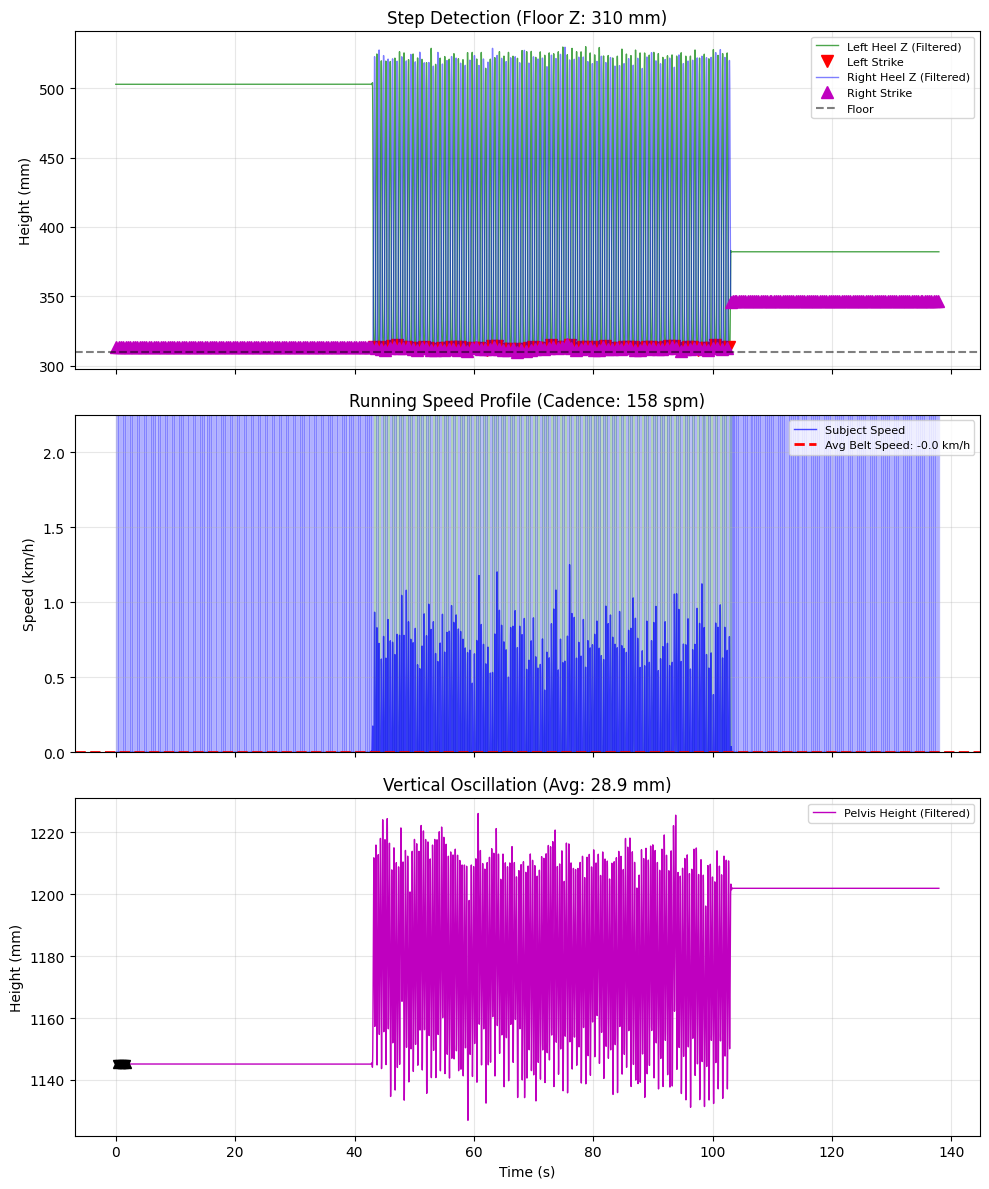


          RUNNING ANALYSIS REPORT
Total Steps: 364 (L:79 R:285)
Recording Duration: 137.9 seconds
--------------------------------------------------
           Metric      Value
   Avg Belt Speed -0.00 km/h
Avg Subject Speed -0.00 km/h
        Max Speed  0.70 km/h
        Min Speed -0.70 km/h
          Cadence  158.4 spm
    Stride Length    -0.00 m
Vert. Oscillation    28.9 mm



In [2]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d

# --- 1. CONFIGURATION ---
filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d'

# --- 2. LOAD DATA ---
try:
    c = ezc3d.c3d(filename)
    points = c['data']['points']
    # Clean labels: strip spaces to ensure ' LHEE' matches 'LHEE'
    labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
    rate = c['parameters']['POINT']['RATE']['value'][0]
    print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
except Exception as e:
    print(f"Error loading file: {e}")
    points = None

# --- 3. HELPER FUNCTIONS ---
def get_marker_data(target_names):
    """Finds marker data, handling missing names and NaNs."""
    if isinstance(target_names, str): target_names = [target_names]
    
    # Find indices
    indices = []
    for name in target_names:
        if name in labels:
            indices.append(labels.index(name))
    
    if not indices:
        print(f"Warning: Markers {target_names} not found in file.")
        return None

    # Get Data (Average if multiple markers, e.g. Pelvis)
    data = np.mean(points[0:3, indices, :], axis=1)
    
    # Fix Zeros (often used as missing value) -> Set to NaN
    data[data == 0] = np.nan
    
    # Interpolate small gaps (up to 10 frames)
    for axis in range(3):
        y = data[axis, :]
        nans, x = np.isnan(y), lambda z: z.nonzero()[0]
        if nans.any() and (~nans).any(): # If we have some data but some gaps
            # Use linear interpolation
            y[nans] = np.interp(x(nans), x(~nans), y[~nans])
            data[axis, :] = y
            
    return data

def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Apply low-pass Butterworth filter to remove noise."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# --- 4. DATA EXTRACTION ---
# Standard marker names (Heel, Toe, Pelvis)
heel_l = get_marker_data(['LHEE', 'L.Heel'])
heel_r = get_marker_data(['RHEE', 'R.Heel'])
pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS'])

if heel_l is None or pelvis is None:
    print("CRITICAL ERROR: Essential markers (Heel/Pelvis) missing. Cannot analyze.")
else:
    # --- 5. DETECT HEEL STRIKES (Robust Method) ---
    # Z-axis is usually vertical (Index 2). Y is forward (Index 1).
    z_idx, y_idx = 2, 1
    
    # Apply low-pass filter to remove marker noise
    cutoff = 10  # Hz
    heel_l_filtered_z = butter_lowpass_filter(heel_l[z_idx, :], cutoff, rate)
    heel_r_filtered_z = butter_lowpass_filter(heel_r[z_idx, :], cutoff, rate)
    
    # Detect floor height (minimum of filtered heel data)
    floor_z = np.min(heel_l_filtered_z)
    print(f"Detected Floor Height: {floor_z:.1f} mm")
    
    # Find heel strikes using velocity method (more reliable)
    # Heel velocity in Z direction
    heel_l_vel_z = np.gradient(heel_l_filtered_z, 1/rate)
    heel_r_vel_z = np.gradient(heel_r_filtered_z, 1/rate)
    
    # Find where heel velocity changes from negative to positive (touchdown)
    min_dist = int(rate * 0.3)  # Minimum 0.3s between steps
    
    # Left heel strikes
    hs_l = []
    for i in range(1, len(heel_l_vel_z)-1):
        if (heel_l_vel_z[i-1] < 0 and heel_l_vel_z[i] >= 0 and 
            heel_l_filtered_z[i] < floor_z + 50):  # Within 50mm of floor
            # Find local minimum within ±5 frames
            search_start = max(0, i-5)
            search_end = min(len(heel_l_filtered_z), i+5)
            if search_start < search_end:
                local_min_idx = np.argmin(heel_l_filtered_z[search_start:search_end]) + search_start
                if len(hs_l) == 0 or (local_min_idx - hs_l[-1] > min_dist):
                    hs_l.append(local_min_idx)
    
    # Right heel strikes
    hs_r = []
    for i in range(1, len(heel_r_vel_z)-1):
        if (heel_r_vel_z[i-1] < 0 and heel_r_vel_z[i] >= 0 and 
            heel_r_filtered_z[i] < floor_z + 50):
            search_start = max(0, i-5)
            search_end = min(len(heel_r_filtered_z), i+5)
            if search_start < search_end:
                local_min_idx = np.argmin(heel_r_filtered_z[search_start:search_end]) + search_start
                if len(hs_r) == 0 or (local_min_idx - hs_r[-1] > min_dist):
                    hs_r.append(local_min_idx)
    
    hs_l = np.array(hs_l)
    hs_r = np.array(hs_r)
    
    print(f"Steps Detected -> Left: {len(hs_l)}, Right: {len(hs_r)}")

    if len(hs_l) < 2 or len(hs_r) < 2:
        print("Not enough steps detected to calculate speed. Check the graph below.")
    else:
        # --- 6. CALCULATE BIOMECHANICS ---
        
        # A. Cadence
        duration_min = points.shape[2] / rate / 60
        cadence = (len(hs_l) + len(hs_r)) / duration_min
        
        # B. Belt Speed Estimation (Treadmill Speed)
        # Better approach: Use pelvis COM velocity during mid-stance when foot is stationary relative to belt
        pelvis_vel_y = np.gradient(pelvis[y_idx, :], 1/rate)  # mm/s
        
        # Apply filter to pelvis velocity
        pelvis_vel_y_filtered = butter_lowpass_filter(pelvis_vel_y, 5, rate)
        
        # Find mid-stance periods (heel is on ground)
        def get_mid_stance_velocities(h_data, strikes, window=0.1):
            """Get velocities during mid-stance periods."""
            velocities = []
            half_window = int(rate * window / 2)
            
            for hs in strikes:
                start = hs + int(0.1 * rate)  # 100ms after heel strike
                end = start + half_window * 2
                
                if end < len(pelvis_vel_y_filtered):
                    # During mid-stance, pelvis velocity should be relatively constant
                    mid_stance_vel = np.mean(pelvis_vel_y_filtered[start:end])
                    velocities.append(mid_stance_vel)
            
            return np.array(velocities)
        
        # Get velocities for both sides
        left_vels = get_mid_stance_velocities(heel_l, hs_l)
        right_vels = get_mid_stance_velocities(heel_r, hs_r)
        
        # Belt speed is the negative of average pelvis velocity during stance
        if len(left_vels) > 0 and len(right_vels) > 0:
            all_vels = np.concatenate([left_vels, right_vels])
            belt_speed_mm_s = -np.median(all_vels)  # Negative because pelvis moves forward, belt moves backward
        else:
            # Fallback: estimate from step frequency and typical stride length
            avg_step_time = np.mean(np.diff(np.sort(np.concatenate([hs_l, hs_r])))) / rate
            avg_stride_time = avg_step_time * 2
            # Typical running stride length ~1.5-2.0 m for comfortable running
            estimated_stride_length = 1.8  # meters
            belt_speed_mm_s = (estimated_stride_length * 1000) / avg_stride_time
            print(f"Using fallback speed estimation: {belt_speed_mm_s/1000*3.6:.1f} km/h")
        
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
        # C. Instantaneous Subject Speed = Belt Speed + Pelvis Velocity
        # Note: When pelvis moves forward relative to lab, subject is actually going faster than belt
        subject_speed_mm_s = belt_speed_mm_s + pelvis_vel_y_filtered
        subject_speed_kph = (subject_speed_mm_s / 1000) * 3.6
        
        # D. Stride Length
        cycle_time_l = np.mean(np.diff(hs_l)) / rate if len(hs_l) > 1 else 1.0
        stride_len_m = (belt_speed_mm_s / 1000) * cycle_time_l
        
        # E. Vertical Oscillation
        # Filter pelvis height data
        pelvis_z_filtered = butter_lowpass_filter(pelvis[z_idx, :], 5, rate)
        oscillations = []
        all_hs = np.sort(np.concatenate((hs_l, hs_r)))
        
        for i in range(len(all_hs)-1):
            start_idx = all_hs[i]
            end_idx = all_hs[i+1]
            if end_idx > start_idx:
                segment = pelvis_z_filtered[start_idx:end_idx]
                oscillations.append(np.max(segment) - np.min(segment))
        
        vert_osc_mm = np.mean(oscillations) if oscillations else 0

        # --- 7. PLOTTING ---
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
        
        t = np.arange(points.shape[2]) / rate
        
        # Plot 1: Step Detection (Verification)
        axs[0].plot(t, heel_l_filtered_z, 'g-', label='Left Heel Z (Filtered)', alpha=0.7, linewidth=1)
        axs[0].plot(t[hs_l], heel_l_filtered_z[hs_l], 'rv', markersize=8, label='Left Strike')
        axs[0].plot(t, heel_r_filtered_z, 'b-', label='Right Heel Z (Filtered)', alpha=0.5, linewidth=1)
        axs[0].plot(t[hs_r], heel_r_filtered_z[hs_r], 'm^', markersize=8, label='Right Strike')
        axs[0].axhline(floor_z, color='k', linestyle='--', alpha=0.5, label='Floor')
        axs[0].set_title(f'Step Detection (Floor Z: {floor_z:.0f} mm)')
        axs[0].set_ylabel('Height (mm)')
        axs[0].legend(loc='upper right', fontsize=8)
        axs[0].grid(True, alpha=0.3)
        
        # Plot 2: Speed Profile
        axs[1].plot(t, subject_speed_kph, 'b-', label='Subject Speed', alpha=0.7, linewidth=1)
        axs[1].axhline(avg_speed_kph, color='r', linestyle='--', 
                      label=f'Avg Belt Speed: {avg_speed_kph:.1f} km/h', linewidth=2)
        
        # Add shaded regions for stance phases
        for hs in hs_l:
            start = max(0, hs - int(0.05*rate))
            end = min(len(t), hs + int(0.3*rate))
            axs[1].axvspan(t[start], t[end-1], alpha=0.2, color='green')
        
        for hs in hs_r:
            start = max(0, hs - int(0.05*rate))
            end = min(len(t), hs + int(0.3*rate))
            axs[1].axvspan(t[start], t[end-1], alpha=0.2, color='blue')
            
        axs[1].set_title(f'Running Speed Profile (Cadence: {cadence:.0f} spm)')
        axs[1].set_ylabel('Speed (km/h)')
        axs[1].legend(loc='upper right', fontsize=8)
        axs[1].grid(True, alpha=0.3)
        axs[1].set_ylim([max(0, np.min(subject_speed_kph)-1), np.max(subject_speed_kph)+1])

        # Plot 3: Vertical Oscillation
        axs[2].plot(t, pelvis_z_filtered, 'm-', label='Pelvis Height (Filtered)', linewidth=1)
        
        # Mark oscillation per stride
        for i in range(min(5, len(all_hs)-1)):  # Show first 5 strides
            start_idx = all_hs[i]
            end_idx = all_hs[i+1]
            if end_idx > start_idx:
                segment = pelvis_z_filtered[start_idx:end_idx]
                max_idx = start_idx + np.argmax(segment)
                min_idx = start_idx + np.argmin(segment)
                axs[2].plot(t[max_idx], pelvis_z_filtered[max_idx], 'k^', markersize=6)
                axs[2].plot(t[min_idx], pelvis_z_filtered[min_idx], 'kv', markersize=6)
                axs[2].plot([t[max_idx], t[min_idx]], 
                          [pelvis_z_filtered[max_idx], pelvis_z_filtered[min_idx]], 
                          'k--', alpha=0.5)
        
        axs[2].set_title(f'Vertical Oscillation (Avg: {vert_osc_mm:.1f} mm)')
        axs[2].set_ylabel('Height (mm)')
        axs[2].set_xlabel('Time (s)')
        axs[2].legend(loc='upper right', fontsize=8)
        axs[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # --- 8. PRINT REPORT ---
        report = pd.DataFrame({
            'Metric': ['Avg Belt Speed', 'Avg Subject Speed', 'Max Speed', 'Min Speed', 
                      'Cadence', 'Stride Length', 'Vert. Oscillation'],
            'Value': [
                f"{avg_speed_kph:.2f} km/h",
                f"{np.median(subject_speed_kph):.2f} km/h",
                f"{np.percentile(subject_speed_kph, 95):.2f} km/h",
                f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
                f"{cadence:.1f} spm",
                f"{stride_len_m:.2f} m",
                f"{vert_osc_mm:.1f} mm"
            ],
            'Description': [
                'Constant treadmill belt speed',
                'Instantaneous speed relative to lab',
                '95th percentile (ignoring noise)',
                '5th percentile (ignoring noise)',
                'Steps per minute',
                'Distance covered per gait cycle',
                'Vertical movement of pelvis per stride'
            ]
        })
        
        print("\n" + "="*50)
        print("          RUNNING ANALYSIS REPORT")
        print("="*50)
        print(f"Total Steps: {len(hs_l) + len(hs_r)} (L:{len(hs_l)} R:{len(hs_r)})")
        print(f"Recording Duration: {points.shape[2]/rate:.1f} seconds")
        print("-"*50)
        print(report[['Metric', 'Value']].to_string(index=False))
        print("\n" + "="*50)

### Overground running

Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d (100.0 Hz). Found 206 markers.
Using specified: OVERGROUND running
Steps Detected -> Left: 4, Right: 3


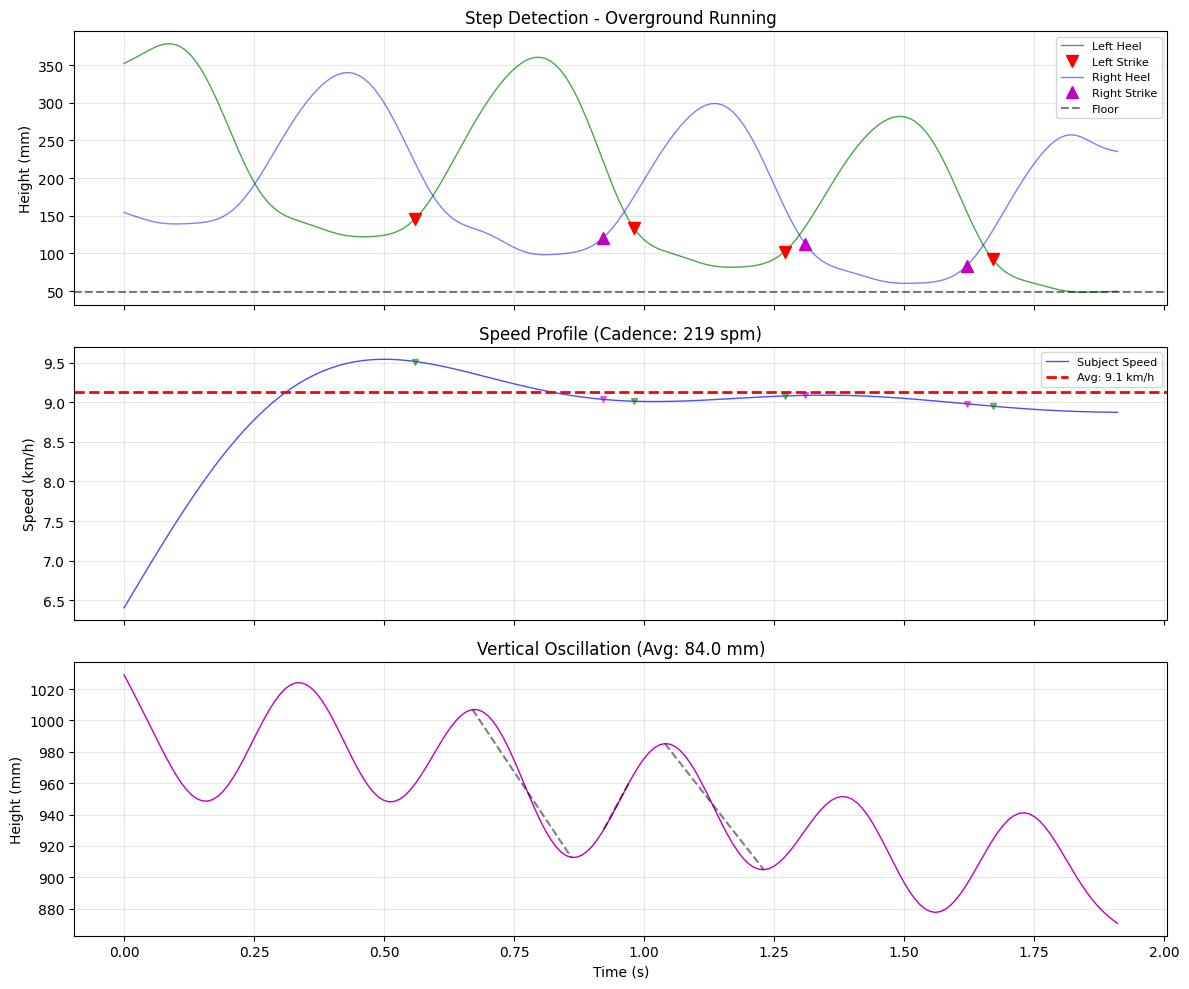


          RUNNING ANALYSIS REPORT
Filename: CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d
Duration: 1.9s, Sample Rate: 100.0Hz
--------------------------------------------------
           Metric       Value
     Running Type  Overground
        Avg Speed   9.13 km/h
        Max Speed   9.52 km/h
        Min Speed   7.44 km/h
          Cadence   218.8 spm
    Stride Length      0.47 m
Vert. Oscillation     84.0 mm
      Total Steps 7 (L:4 R:3)


In [3]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d

def analyze_running_c3d(filename, running_type='auto'):
    """
    Analyze running biomechanics from C3D file.
    
    Parameters:
    -----------
    filename : str
        Path to C3D file
    running_type : str
        'auto' - automatically detect treadmill/overground
        'treadmill' - force treadmill analysis
        'overground' - force overground analysis
    """
    
    # --- LOAD DATA ---
    try:
        c = ezc3d.c3d(filename)
        points = c['data']['points']
        labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
        rate = c['parameters']['POINT']['RATE']['value'][0]
        print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # --- HELPER FUNCTIONS ---
    def get_marker_data(target_names):
        if isinstance(target_names, str): target_names = [target_names]
        
        indices = []
        for name in target_names:
            if name in labels:
                indices.append(labels.index(name))
        
        if not indices:
            print(f"Warning: Markers {target_names} not found.")
            return None

        data = np.mean(points[0:3, indices, :], axis=1)
        data[data == 0] = np.nan
        
        for axis in range(3):
            y = data[axis, :]
            nans, x = np.isnan(y), lambda z: z.nonzero()[0]
            if nans.any() and (~nans).any():
                y[nans] = np.interp(x(nans), x(~nans), y[~nans])
                data[axis, :] = y
                
        return data
    
    def butter_lowpass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)
    
    # --- GET MARKER DATA ---
    heel_l = get_marker_data(['LHEE', 'L.Heel', 'LANK', 'LANKLE'])
    heel_r = get_marker_data(['RHEE', 'R.Heel', 'RANK', 'RANKLE'])
    pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS', 'SACR'])
    
    if heel_l is None or pelvis is None:
        print("CRITICAL ERROR: Essential markers missing.")
        return None
    
    # --- DETECT RUNNING TYPE ---
    if running_type == 'auto':
        # Auto-detect: Check if subject stays in same place (treadmill)
        # vs moves forward (overground)
        pelvis_y = pelvis[1, :]  # Forward direction (usually Y)
        total_travel = np.max(pelvis_y) - np.min(pelvis_y)
        
        # If total travel is small relative to typical stride length, it's treadmill
        if total_travel < 1000:  # Less than 1 meter total travel
            print("Detected: TREADMILL running (subject stays in place)")
            running_type = 'treadmill'
        else:
            print(f"Detected: OVERGROUND running (subject travels {total_travel:.0f} mm)")
            running_type = 'overground'
    else:
        print(f"Using specified: {running_type.upper()} running")
    
    # --- STEP DETECTION ---
    z_idx, y_idx = 2, 1
    
    # Filter heel data
    cutoff = 10
    heel_l_z = butter_lowpass_filter(heel_l[z_idx, :], cutoff, rate)
    heel_r_z = butter_lowpass_filter(heel_r[z_idx, :], cutoff, rate)
    
    # Find floor/ground level
    floor_z = np.min(np.concatenate([heel_l_z, heel_r_z]))
    
    # Find peaks in vertical acceleration (more robust)
    heel_l_acc = np.gradient(np.gradient(heel_l_z, 1/rate), 1/rate)
    heel_r_acc = np.gradient(np.gradient(heel_r_z, 1/rate), 1/rate)
    
    # Find heel strikes (positive peaks in acceleration after low-pass)
    acc_cutoff = 6
    heel_l_acc_filt = butter_lowpass_filter(heel_l_acc, acc_cutoff, rate)
    heel_r_acc_filt = butter_lowpass_filter(heel_r_acc, acc_cutoff, rate)
    
    min_dist = int(rate * 0.25)  # Minimum 0.25s between steps
    
    # Find heel strikes
    hs_l, _ = find_peaks(heel_l_acc_filt, height=np.std(heel_l_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_l_acc_filt)*0.5)
    hs_r, _ = find_peaks(heel_r_acc_filt, height=np.std(heel_r_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_r_acc_filt)*0.5)
    
    # Filter: heel must be near ground at impact
    hs_l = hs_l[heel_l_z[hs_l] < floor_z + 100]
    hs_r = hs_r[heel_r_z[hs_r] < floor_z + 100]
    
    print(f"Steps Detected -> Left: {len(hs_l)}, Right: {len(hs_r)}")
    
    if len(hs_l) < 2 or len(hs_r) < 2:
        print("Insufficient steps detected.")
        return None
    
    # --- CALCULATE BIOMECHANICS ---
    t = np.arange(points.shape[2]) / rate
    
    # 1. Cadence
    duration_min = len(t) / rate / 60
    cadence = (len(hs_l) + len(hs_r)) / duration_min
    
    # 2. Speed Calculation (DIFFERENT FOR TREADMILL vs OVERGROUND)
    pelvis_y = pelvis[1, :]
    pelvis_y_filt = butter_lowpass_filter(pelvis_y, 5, rate)
    pelvis_vel_y = np.gradient(pelvis_y_filt, 1/rate)  # mm/s
    
    if running_type == 'treadmill':
        # For treadmill: Speed = belt speed + pelvis velocity
        # Estimate belt speed from pelvis velocity during stance
        stance_velocities = []
        
        for hs in np.concatenate([hs_l, hs_r]):
            # Look at window 100-300ms after heel strike (mid-stance)
            start = hs + int(0.1 * rate)
            end = hs + int(0.3 * rate)
            if end < len(pelvis_vel_y):
                stance_vel = np.mean(pelvis_vel_y[start:end])
                stance_velocities.append(stance_vel)
        
        if stance_velocities:
            belt_speed_mm_s = -np.median(stance_velocities)
        else:
            # Fallback: estimate from typical running speed
            belt_speed_mm_s = 3000  # ~10.8 km/h typical
        
        subject_speed_mm_s = belt_speed_mm_s + pelvis_vel_y
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
    else:  # Overground
        # For overground: Speed = direct pelvis velocity
        # Filter heavily to get smooth speed estimate
        subject_speed_mm_s = pelvis_vel_y
        speed_filt = butter_lowpass_filter(subject_speed_mm_s, 1, rate)  # 1 Hz cutoff
        
        # Average speed during running (ignore start/stop)
        # Use middle 80% of data to avoid acceleration/deceleration
        start_idx = int(0.1 * len(speed_filt))
        end_idx = int(0.9 * len(speed_filt))
        avg_speed_mm_s = np.mean(speed_filt[start_idx:end_idx])
        avg_speed_kph = (avg_speed_mm_s / 1000) * 3.6
        
        subject_speed_mm_s = speed_filt  # Use filtered speed
    
    subject_speed_kph = (subject_speed_mm_s / 1000) * 3.6
    
    # 3. Stride Length
    if running_type == 'treadmill':
        cycle_time_l = np.mean(np.diff(hs_l)) / rate if len(hs_l) > 1 else 0
        stride_len_m = (avg_speed_kph / 3.6) * (cycle_time_l / 1000)  # Convert properly
    else:
        # For overground: stride length = speed * stride time
        all_hs = np.sort(np.concatenate([hs_l, hs_r]))
        stride_times = np.diff(all_hs) / rate
        if len(stride_times) > 0:
            avg_stride_time = np.mean(stride_times)
            stride_len_m = (avg_speed_kph / 3.6) * avg_stride_time
        else:
            stride_len_m = 0
    
    # 4. Vertical Oscillation
    pelvis_z_filt = butter_lowpass_filter(pelvis[2, :], 5, rate)
    oscillations = []
    all_hs = np.sort(np.concatenate([hs_l, hs_r]))
    
    for i in range(len(all_hs)-1):
        start, end = all_hs[i], all_hs[i+1]
        if end - start > int(0.3 * rate):  # Valid stride
            segment = pelvis_z_filt[start:end]
            oscillations.append(np.max(segment) - np.min(segment))
    
    vert_osc_mm = np.mean(oscillations) if oscillations else 0
    
    # --- CREATE REPORT ---
    report = pd.DataFrame({
        'Metric': ['Running Type', 'Avg Speed', 'Max Speed', 'Min Speed', 
                  'Cadence', 'Stride Length', 'Vert. Oscillation', 'Total Steps'],
        'Value': [
            running_type.title(),
            f"{avg_speed_kph:.2f} km/h",
            f"{np.percentile(subject_speed_kph, 95):.2f} km/h",
            f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
            f"{cadence:.1f} spm",
            f"{stride_len_m:.2f} m",
            f"{vert_osc_mm:.1f} mm",
            f"{len(hs_l) + len(hs_r)} (L:{len(hs_l)} R:{len(hs_r)})"
        ]
    })
    
    # --- PLOT ---
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Step Detection
    axs[0].plot(t, heel_l_z, 'g-', label='Left Heel', alpha=0.7, linewidth=1)
    axs[0].plot(t[hs_l], heel_l_z[hs_l], 'rv', markersize=8, label='Left Strike')
    axs[0].plot(t, heel_r_z, 'b-', label='Right Heel', alpha=0.5, linewidth=1)
    axs[0].plot(t[hs_r], heel_r_z[hs_r], 'm^', markersize=8, label='Right Strike')
    axs[0].axhline(floor_z, color='k', linestyle='--', alpha=0.5, label='Floor')
    axs[0].set_ylabel('Height (mm)')
    axs[0].set_title(f'Step Detection - {running_type.title()} Running')
    axs[0].legend(loc='upper right', fontsize=8)
    axs[0].grid(True, alpha=0.3)
    
    # Plot 2: Speed Profile
    axs[1].plot(t, subject_speed_kph, 'b-', label='Subject Speed', alpha=0.7, linewidth=1)
    axs[1].axhline(avg_speed_kph, color='r', linestyle='--', 
                   label=f'Avg: {avg_speed_kph:.1f} km/h', linewidth=2)
    
    # Mark heel strikes
    axs[1].plot(t[hs_l], subject_speed_kph[hs_l], 'gv', alpha=0.5, markersize=4)
    axs[1].plot(t[hs_r], subject_speed_kph[hs_r], 'mv', alpha=0.5, markersize=4)
    
    axs[1].set_ylabel('Speed (km/h)')
    axs[1].set_title(f'Speed Profile (Cadence: {cadence:.0f} spm)')
    axs[1].legend(loc='upper right', fontsize=8)
    axs[1].grid(True, alpha=0.3)
    
    # Plot 3: Vertical Oscillation
    axs[2].plot(t, pelvis_z_filt, 'm-', label='Pelvis Height', linewidth=1)
    
    # Mark oscillations for first 3 strides
    for i in range(min(3, len(all_hs)-1)):
        start, end = all_hs[i], all_hs[i+1]
        if end > start:
            segment = pelvis_z_filt[start:end]
            max_idx = start + np.argmax(segment)
            min_idx = start + np.argmin(segment)
            axs[2].plot([t[max_idx], t[min_idx]], 
                       [pelvis_z_filt[max_idx], pelvis_z_filt[min_idx]], 
                       'k--', alpha=0.5)
    
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Height (mm)')
    axs[2].set_title(f'Vertical Oscillation (Avg: {vert_osc_mm:.1f} mm)')
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- PRINT REPORT ---
    print("\n" + "="*50)
    print("          RUNNING ANALYSIS REPORT")
    print("="*50)
    print(f"Filename: {filename.split('/')[-1]}")
    print(f"Duration: {t[-1]:.1f}s, Sample Rate: {rate}Hz")
    print("-"*50)
    print(report.to_string(index=False))
    print("="*50)
    
    return {
        'report': report,
        'running_type': running_type,
        'speeds_kph': subject_speed_kph,
        'cadence': cadence,
        'stride_length': stride_len_m,
        'vertical_oscillation': vert_osc_mm,
        'heel_strikes': {'left': hs_l, 'right': hs_r},
        'time': t
    }

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    # For treadmill running (auto-detect or specify)
    # results = analyze_running_c3d('your_file.c3d', running_type='auto')
    
    # For overground running
    results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable1.c3d', running_type='overground')

Starting running biomechanics analysis...
Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d (100.0 Hz). Found 206 markers.

Loading marker data...
Detected: TREADMILL running

Detecting steps...
Steps Detected -> Total: 158, L: 79, R: 79

Calculating joint angles...
  Left Knee: 165.0° ± 6.4°
  Right Knee: 170.7° ± 3.1°
  Left Hip: 173.9° ± 2.7°
  Right Hip: 172.6° ± 1.3°
  Left Ankle: 141.5° ± 49.0°
  Right Ankle: 86.9° ± 45.3°
  Left Elbow: 85.5° ± 6.6°
  Right Elbow: 94.6° ± 4.7°
  Trunk Lean: 81.0° ± 1.8°
  Pelvic Tilt: -1.5° ± 2.4°

Calculating basic biomechanics...

              COMPREHENSIVE RUNNING ANALYSIS

BASIC METRICS:
----------------------------------------
           Metric           Value
     Running Type       Treadmill
         Duration          137.9s
        Avg Speed      -0.02 km/h
        Max Speed       0.17 km/h
        Min Speed      -0.20 km/h
          

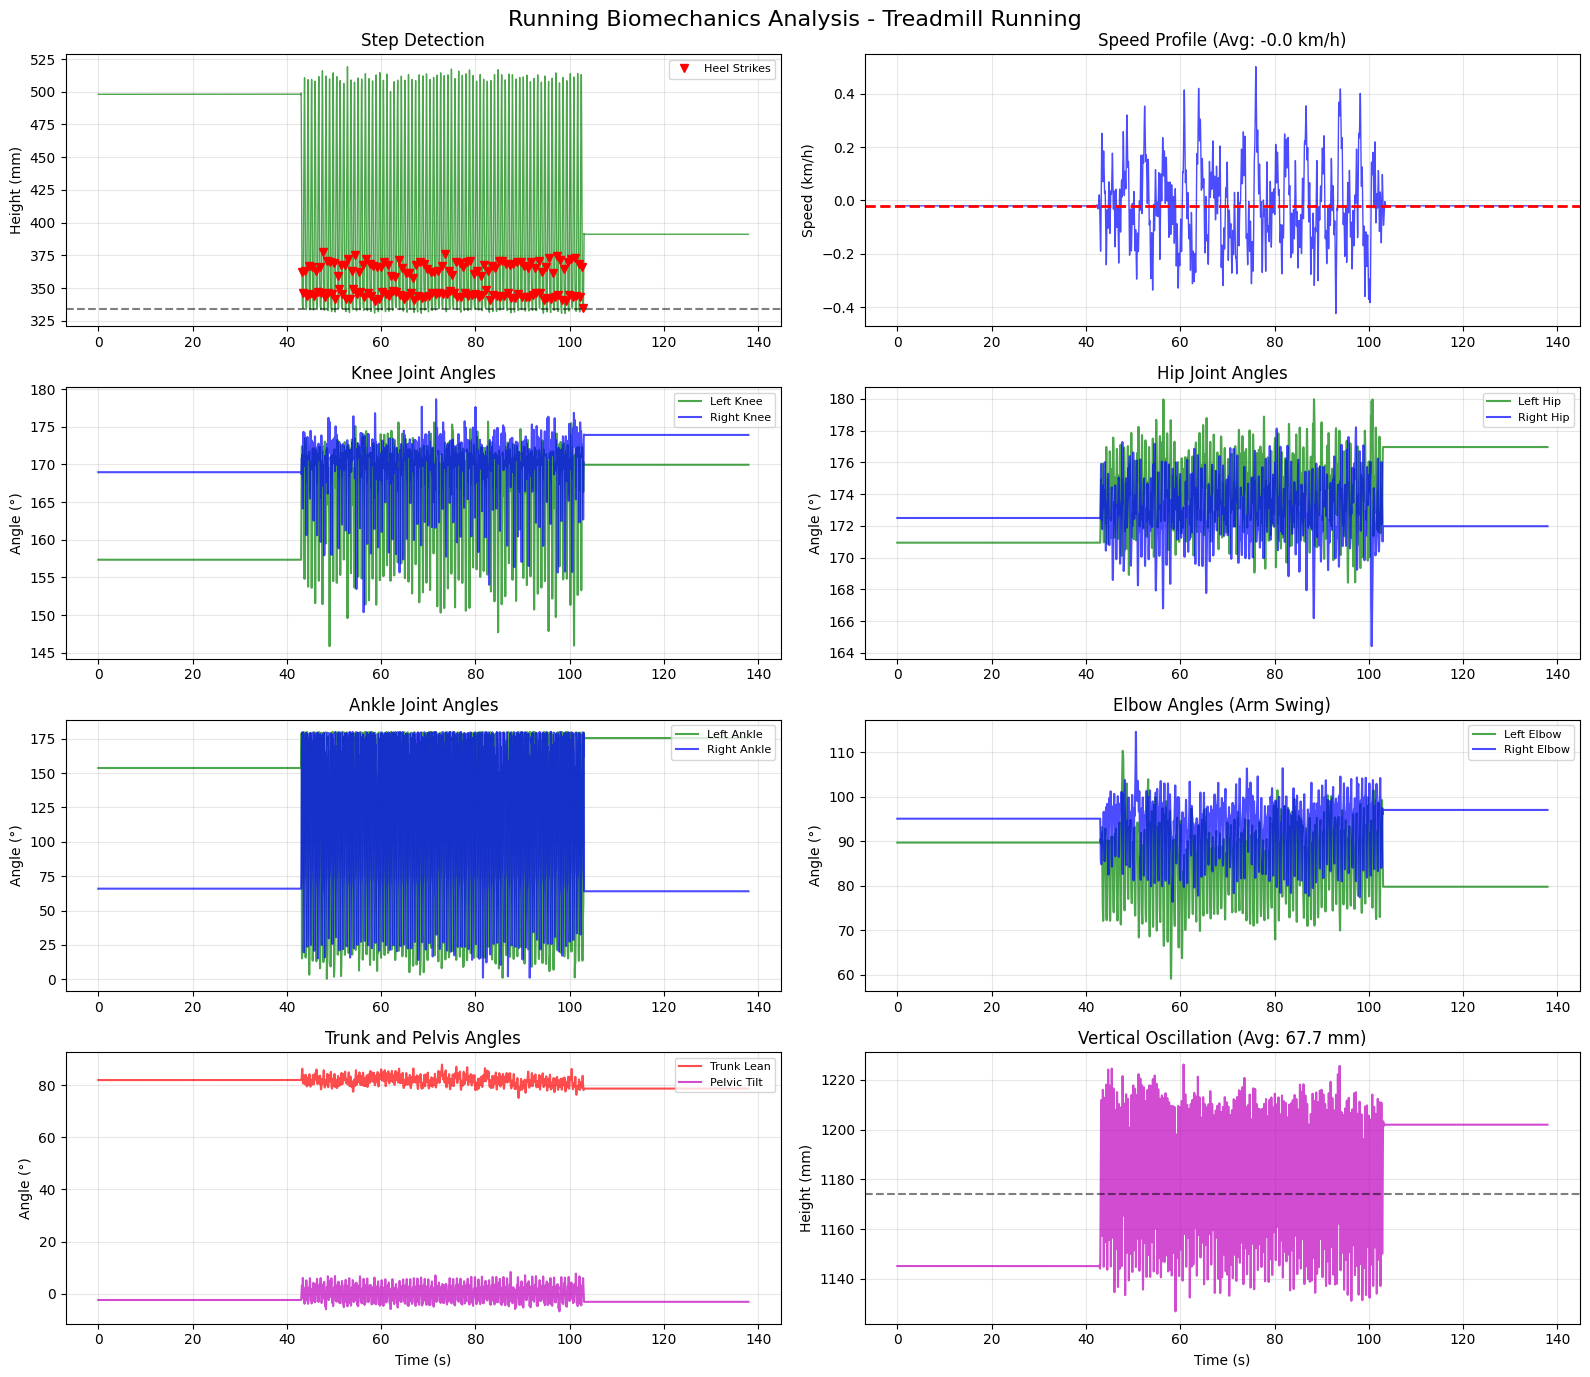


Analysis complete! Use results['angles'] to access joint angle data.
Available angles: ['knee_left', 'knee_right', 'hip_left', 'hip_right', 'ankle_left', 'ankle_right', 'elbow_left', 'elbow_right', 'trunk_lean', 'pelvic_tilt']


In [4]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d
import math

def analyze_running_c3d(filename, running_type='auto'):
    """
    Analyze running biomechanics including joint angles from C3D file.
    
    Parameters:
    -----------
    filename : str
        Path to C3D file
    running_type : str
        'auto' - automatically detect treadmill/overground
        'treadmill' - force treadmill analysis
        'overground' - force overground analysis
    """
    
    # --- LOAD DATA ---
    try:
        c = ezc3d.c3d(filename)
        points = c['data']['points']
        labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
        rate = c['parameters']['POINT']['RATE']['value'][0]
        print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # --- HELPER FUNCTIONS ---
    def get_marker_data(target_names):
        if isinstance(target_names, str): target_names = [target_names]
        
        indices = []
        for name in target_names:
            if name in labels:
                indices.append(labels.index(name))
        
        if not indices:
            print(f"Warning: Markers {target_names} not found.")
            return None

        data = np.mean(points[0:3, indices, :], axis=1)
        data[data == 0] = np.nan
        
        for axis in range(3):
            y = data[axis, :]
            nans, x = np.isnan(y), lambda z: z.nonzero()[0]
            if nans.any() and (~nans).any():
                y[nans] = np.interp(x(nans), x(~nans), y[~nans])
                data[axis, :] = y
                
        return data
    
    def butter_lowpass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)
    
    def calculate_angle_3d(A, B, C):
        """
        Calculate angle ABC in 3D space.
        A, B, C are (x,y,z) coordinates for points A, B, C.
        Returns angle at point B in degrees.
        """
        # Create vectors BA and BC
        BA = A - B
        BC = C - B
        
        # Calculate dot product and magnitudes
        dot_product = np.sum(BA * BC, axis=0)
        mag_BA = np.linalg.norm(BA, axis=0)
        mag_BC = np.linalg.norm(BC, axis=0)
        
        # Avoid division by zero
        mag_product = mag_BA * mag_BC
        mag_product[mag_product == 0] = 1e-10
        
        # Calculate cosine of angle
        cos_angle = dot_product / mag_product
        
        # Clamp to [-1, 1] to avoid numerical errors
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        
        # Convert to degrees
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        return angle_deg
    
    def calculate_sagittal_plane_angle(A, B, C):
        """
        Calculate angle in sagittal plane (X-Z plane for forward motion).
        Assumes Y-axis is forward direction.
        """
        # Project to sagittal plane (X-Z plane)
        A_sag = np.array([A[0, :], A[2, :]])  # X, Z coordinates
        B_sag = np.array([B[0, :], B[2, :]])
        C_sag = np.array([C[0, :], C[2, :]])
        
        return calculate_angle_3d(A_sag, B_sag, C_sag)
    
    def calculate_trunk_lean(shoulder, hip, vertical_ref=None):
        """
        Calculate trunk lean angle from vertical.
        shoulder, hip: 3D coordinates
        Returns angle from vertical in degrees.
        """
        # Vector from hip to shoulder
        trunk_vector = shoulder - hip
        
        # Vertical reference vector (downward/upward depending on coordinate system)
        if vertical_ref is None:
            # Assuming Z is vertical (upward positive)
            vertical_vector = np.array([[0], [0], [1]])  # Upward vector
        else:
            vertical_vector = vertical_ref
        
        # Calculate angle between trunk and vertical
        dot_product = np.sum(trunk_vector * vertical_vector, axis=0)
        mag_trunk = np.linalg.norm(trunk_vector, axis=0)
        mag_vertical = np.linalg.norm(vertical_vector)
        
        cos_angle = dot_product / (mag_trunk * mag_vertical)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        # Adjust for forward lean (angle from vertical)
        return 90 - angle_deg  # 0 = upright, positive = forward lean
    
    def calculate_pelvic_tilt(L_hip, R_hip, L_shoulder=None, R_shoulder=None):
        """
        Calculate pelvic tilt angle in frontal plane.
        Positive = left side up, negative = right side up
        """
        # Calculate vertical difference between left and right hips
        vertical_diff = L_hip[2, :] - R_hip[2, :]
        
        # Calculate horizontal distance between hips
        horizontal_dist = np.linalg.norm(L_hip[0:2, :] - R_hip[0:2, :], axis=0)
        
        # Avoid division by zero
        horizontal_dist[horizontal_dist == 0] = 1e-10
        
        # Calculate tilt angle (arctan of vertical difference / horizontal distance)
        tilt_rad = np.arctan2(vertical_diff, horizontal_dist)
        tilt_deg = np.degrees(tilt_rad)
        
        return tilt_deg
    
    # --- GET MARKER DATA ---
    print("\nLoading marker data...")
    
    # Lower body markers
    L_heel = get_marker_data(['LHEE', 'L.Heel', 'LANK', 'LANKLE', 'LHEEL'])
    R_heel = get_marker_data(['RHEE', 'R.Heel', 'RANK', 'RANKLE', 'RHEEL'])
    L_toe = get_marker_data(['LTOE', 'L.Toe', 'LTOE2', 'LMT5', 'LMT1'])
    R_toe = get_marker_data(['RTOE', 'R.Toe', 'RTOE2', 'RMT5', 'RMT1'])
    L_knee = get_marker_data(['LKNE', 'L.Knee', 'LKNE', 'LKNEE'])
    R_knee = get_marker_data(['RKNE', 'R.Knee', 'RKNE', 'RKNEE'])
    L_hip = get_marker_data(['LASI', 'L.Hip', 'LPSI', 'LGT', 'LFTC', 'LTHI'])
    R_hip = get_marker_data(['RASI', 'R.Hip', 'RPSI', 'RGT', 'RFTC', 'RTHI'])
    L_ankle = get_marker_data(['LANK', 'L.Ankle', 'LHEE', 'LANKLE'])
    R_ankle = get_marker_data(['RANK', 'R.Ankle', 'RHEE', 'RANKLE'])
    
    # Upper body markers
    L_shoulder = get_marker_data(['LACR', 'L.Shoulder', 'LACRM', 'LSHO'])
    R_shoulder = get_marker_data(['RACR', 'R.Shoulder', 'RACRM', 'RSHO'])
    L_elbow = get_marker_data(['LELB', 'L.Elbow', 'LUPA'])
    R_elbow = get_marker_data(['RELB', 'R.Elbow', 'RUPA'])
    L_wrist = get_marker_data(['LWRA', 'L.Wrist', 'LWRB', 'LFIN'])
    R_wrist = get_marker_data(['RWRA', 'R.Wrist', 'RWRB', 'RFIN'])
    
    # Trunk/pelvis markers
    pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS', 'SACR'])
    trunk = get_marker_data(['C7', 'T10', 'CLAV', 'STRN'])
    
    if pelvis is None:
        print("CRITICAL ERROR: Pelvis markers missing.")
        return None
    
    # --- DETECT RUNNING TYPE ---
    if running_type == 'auto':
        pelvis_y = pelvis[1, :]
        total_travel = np.max(pelvis_y) - np.min(pelvis_y)
        
        if total_travel < 1000:
            print("Detected: TREADMILL running")
            running_type = 'treadmill'
        else:
            print(f"Detected: OVERGROUND running (travel: {total_travel:.0f} mm)")
            running_type = 'overground'
    else:
        print(f"Using: {running_type.upper()} running")
    
    # --- STEP DETECTION ---
    print("\nDetecting steps...")
    z_idx, y_idx = 2, 1
    
    # Use heel data for step detection
    if L_heel is not None:
        heel_z = L_heel[z_idx, :]
    else:
        heel_z = pelvis[z_idx, :]
    
    heel_z_filt = butter_lowpass_filter(heel_z, 10, rate)
    floor_z = np.percentile(heel_z_filt, 5)
    
    # Find heel strikes using vertical velocity
    heel_vel_z = np.gradient(heel_z_filt, 1/rate)
    heel_acc_z = np.gradient(heel_vel_z, 1/rate)
    heel_acc_filt = butter_lowpass_filter(heel_acc_z, 6, rate)
    
    min_dist = int(rate * 0.25)
    hs_indices, _ = find_peaks(heel_acc_filt, height=np.std(heel_acc_filt), 
                               distance=min_dist, prominence=np.std(heel_acc_filt)*0.5)
    
    # Filter by height
    hs_indices = hs_indices[heel_z_filt[hs_indices] < floor_z + 80]
    
    # Split into left/right (alternating assumption)
    hs_l = hs_indices[::2]
    hs_r = hs_indices[1::2] if len(hs_indices) > 1 else np.array([])
    
    print(f"Steps Detected -> Total: {len(hs_indices)}, L: {len(hs_l)}, R: {len(hs_r)}")
    
    if len(hs_indices) < 4:
        print("Insufficient steps for analysis.")
        return None
    
    # --- CALCULATE JOINT ANGLES ---
    print("\nCalculating joint angles...")
    t = np.arange(points.shape[2]) / rate
    
    # Initialize angle dictionaries
    angles = {}
    
    # 1. KNEE JOINT ANGLE (Hip-Knee-Ankle)
    if all(m is not None for m in [L_hip, L_knee, L_ankle]):
        angles['knee_left'] = calculate_sagittal_plane_angle(L_hip, L_knee, L_ankle)
        print(f"  Left Knee: {np.mean(angles['knee_left']):.1f}° ± {np.std(angles['knee_left']):.1f}°")
    
    if all(m is not None for m in [R_hip, R_knee, R_ankle]):
        angles['knee_right'] = calculate_sagittal_plane_angle(R_hip, R_knee, R_ankle)
        print(f"  Right Knee: {np.mean(angles['knee_right']):.1f}° ± {np.std(angles['knee_right']):.1f}°")
    
    # 2. HIP JOINT ANGLE (Shoulder-Hip-Knee)
    if all(m is not None for m in [L_shoulder, L_hip, L_knee]):
        angles['hip_left'] = calculate_sagittal_plane_angle(L_shoulder, L_hip, L_knee)
        print(f"  Left Hip: {np.mean(angles['hip_left']):.1f}° ± {np.std(angles['hip_left']):.1f}°")
    
    if all(m is not None for m in [R_shoulder, R_hip, R_knee]):
        angles['hip_right'] = calculate_sagittal_plane_angle(R_shoulder, R_hip, R_knee)
        print(f"  Right Hip: {np.mean(angles['hip_right']):.1f}° ± {np.std(angles['hip_right']):.1f}°")
    
    # 3. ANKLE JOINT ANGLE (Knee-Ankle-Foot)
    # Use toe or heel as foot marker
    L_foot = L_toe if L_toe is not None else L_heel
    R_foot = R_toe if R_toe is not None else R_heel
    
    if all(m is not None for m in [L_knee, L_ankle, L_foot]):
        angles['ankle_left'] = calculate_sagittal_plane_angle(L_knee, L_ankle, L_foot)
        print(f"  Left Ankle: {np.mean(angles['ankle_left']):.1f}° ± {np.std(angles['ankle_left']):.1f}°")
    
    if all(m is not None for m in [R_knee, R_ankle, R_foot]):
        angles['ankle_right'] = calculate_sagittal_plane_angle(R_knee, R_ankle, R_foot)
        print(f"  Right Ankle: {np.mean(angles['ankle_right']):.1f}° ± {np.std(angles['ankle_right']):.1f}°")
    
    # 4. ELBOW ANGLE (Shoulder-Elbow-Wrist)
    if all(m is not None for m in [L_shoulder, L_elbow, L_wrist]):
        angles['elbow_left'] = calculate_angle_3d(L_shoulder, L_elbow, L_wrist)
        print(f"  Left Elbow: {np.mean(angles['elbow_left']):.1f}° ± {np.std(angles['elbow_left']):.1f}°")
    
    if all(m is not None for m in [R_shoulder, R_elbow, R_wrist]):
        angles['elbow_right'] = calculate_angle_3d(R_shoulder, R_elbow, R_wrist)
        print(f"  Right Elbow: {np.mean(angles['elbow_right']):.1f}° ± {np.std(angles['elbow_right']):.1f}°")
    
    # 5. TRUNK LEAN (Vertical vs. Hip-Shoulder line)
    if trunk is not None:
        trunk_ref = trunk
    elif L_shoulder is not None and R_shoulder is not None:
        # Average of left and right shoulders
        trunk_ref = (L_shoulder + R_shoulder) / 2
    else:
        trunk_ref = None
    
    if trunk_ref is not None:
        angles['trunk_lean'] = calculate_trunk_lean(trunk_ref, pelvis)
        print(f"  Trunk Lean: {np.mean(angles['trunk_lean']):.1f}° ± {np.std(angles['trunk_lean']):.1f}°")
    
    # 6. PELVIC TILT (Hip-to-hip horizontal alignment)
    if L_hip is not None and R_hip is not None:
        angles['pelvic_tilt'] = calculate_pelvic_tilt(L_hip, R_hip)
        print(f"  Pelvic Tilt: {np.mean(angles['pelvic_tilt']):.1f}° ± {np.std(angles['pelvic_tilt']):.1f}°")
    
    # --- CALCULATE BASIC BIOMECHANICS ---
    print("\nCalculating basic biomechanics...")
    
    # Cadence
    duration_min = len(t) / rate / 60
    cadence = len(hs_indices) / duration_min
    
    # Speed
    pelvis_vel_y = np.gradient(pelvis[1, :], 1/rate)
    pelvis_vel_filt = butter_lowpass_filter(pelvis_vel_y, 2, rate)
    
    if running_type == 'treadmill':
        # Treadmill speed estimation
        stance_speeds = []
        for hs in hs_indices:
            start = hs + int(0.1 * rate)
            end = hs + int(0.3 * rate)
            if end < len(pelvis_vel_filt):
                stance_speeds.append(np.mean(pelvis_vel_filt[start:end]))
        
        belt_speed = -np.median(stance_speeds) if stance_speeds else 3000
        subject_speed = belt_speed + pelvis_vel_filt
        avg_speed = (belt_speed / 1000) * 3.6
    else:
        # Overground speed
        subject_speed = pelvis_vel_filt
        mid_start = int(0.1 * len(subject_speed))
        mid_end = int(0.9 * len(subject_speed))
        avg_speed_mm_s = np.mean(subject_speed[mid_start:mid_end])
        avg_speed = (avg_speed_mm_s / 1000) * 3.6
    
    subject_speed_kph = (subject_speed / 1000) * 3.6
    
    # Stride Length
    if len(hs_indices) > 1:
        stride_time = np.mean(np.diff(hs_indices)) / rate
        stride_len = (avg_speed / 3.6) * stride_time
    else:
        stride_len = 0
    
    # Vertical Oscillation
    pelvis_z_filt = butter_lowpass_filter(pelvis[2, :], 5, rate)
    oscillations = []
    for i in range(len(hs_indices)-1):
        start, end = hs_indices[i], hs_indices[i+1]
        if end - start > int(0.3 * rate):
            segment = pelvis_z_filt[start:end]
            oscillations.append(np.max(segment) - np.min(segment))
    
    vert_osc = np.mean(oscillations) if oscillations else 0
    
    # --- CREATE COMPREHENSIVE REPORT ---
    print("\n" + "="*60)
    print("              COMPREHENSIVE RUNNING ANALYSIS")
    print("="*60)
    
    # Basic metrics
    basic_metrics = pd.DataFrame({
        'Metric': ['Running Type', 'Duration', 'Avg Speed', 'Max Speed', 'Min Speed',
                  'Cadence', 'Stride Length', 'Vert. Oscillation', 'Total Steps'],
        'Value': [
            running_type.title(),
            f"{t[-1]:.1f}s",
            f"{avg_speed:.2f} km/h",
            f"{np.percentile(subject_speed_kph, 95):.2f} km/h",
            f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
            f"{cadence:.1f} spm",
            f"{stride_len:.2f} m",
            f"{vert_osc:.1f} mm",
            f"{len(hs_indices)} (L:{len(hs_l)} R:{len(hs_r)})"
        ]
    })
    
    print("\nBASIC METRICS:")
    print("-"*40)
    print(basic_metrics.to_string(index=False))
    
    # Joint angle metrics
    angle_data = []
    for angle_name, angle_values in angles.items():
        angle_data.append({
            'Joint': angle_name.replace('_', ' ').title(),
            'Mean (°)': f"{np.nanmean(angle_values):.1f}",
            'Std (°)': f"{np.nanstd(angle_values):.1f}",
            'Min (°)': f"{np.nanmin(angle_values):.1f}",
            'Max (°)': f"{np.nanmax(angle_values):.1f}",
            'Range (°)': f"{np.nanmax(angle_values) - np.nanmin(angle_values):.1f}"
        })
    
    if angle_data:
        angle_df = pd.DataFrame(angle_data)
        print("\n\nJOINT ANGLE ANALYSIS:")
        print("-"*60)
        print(angle_df.to_string(index=False))
    
    # --- PLOTTING ---
    fig, axs = plt.subplots(4, 2, figsize=(16, 14))
    fig.suptitle(f'Running Biomechanics Analysis - {running_type.title()} Running', fontsize=16)
    
    # Plot 1: Step Detection
    axs[0, 0].plot(t, heel_z_filt, 'g-', alpha=0.7, linewidth=1)
    axs[0, 0].plot(t[hs_indices], heel_z_filt[hs_indices], 'rv', markersize=6, label='Heel Strikes')
    axs[0, 0].axhline(floor_z, color='k', linestyle='--', alpha=0.5)
    axs[0, 0].set_ylabel('Height (mm)')
    axs[0, 0].set_title('Step Detection')
    axs[0, 0].legend(loc='upper right', fontsize=8)
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Speed Profile
    axs[0, 1].plot(t, subject_speed_kph, 'b-', alpha=0.7, linewidth=1)
    axs[0, 1].axhline(avg_speed, color='r', linestyle='--', linewidth=2)
    axs[0, 1].set_ylabel('Speed (km/h)')
    axs[0, 1].set_title(f'Speed Profile (Avg: {avg_speed:.1f} km/h)')
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot 3-4: Knee Angles
    if 'knee_left' in angles:
        axs[1, 0].plot(t, angles['knee_left'], 'g-', label='Left Knee', alpha=0.7)
    if 'knee_right' in angles:
        axs[1, 0].plot(t, angles['knee_right'], 'b-', label='Right Knee', alpha=0.7)
    axs[1, 0].set_ylabel('Angle (°)')
    axs[1, 0].set_title('Knee Joint Angles')
    axs[1, 0].legend(loc='upper right', fontsize=8)
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Hip Angles
    if 'hip_left' in angles:
        axs[1, 1].plot(t, angles['hip_left'], 'g-', label='Left Hip', alpha=0.7)
    if 'hip_right' in angles:
        axs[1, 1].plot(t, angles['hip_right'], 'b-', label='Right Hip', alpha=0.7)
    axs[1, 1].set_ylabel('Angle (°)')
    axs[1, 1].set_title('Hip Joint Angles')
    axs[1, 1].legend(loc='upper right', fontsize=8)
    axs[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Ankle Angles
    if 'ankle_left' in angles:
        axs[2, 0].plot(t, angles['ankle_left'], 'g-', label='Left Ankle', alpha=0.7)
    if 'ankle_right' in angles:
        axs[2, 0].plot(t, angles['ankle_right'], 'b-', label='Right Ankle', alpha=0.7)
    axs[2, 0].set_ylabel('Angle (°)')
    axs[2, 0].set_title('Ankle Joint Angles')
    axs[2, 0].legend(loc='upper right', fontsize=8)
    axs[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Elbow Angles
    if 'elbow_left' in angles:
        axs[2, 1].plot(t, angles['elbow_left'], 'g-', label='Left Elbow', alpha=0.7)
    if 'elbow_right' in angles:
        axs[2, 1].plot(t, angles['elbow_right'], 'b-', label='Right Elbow', alpha=0.7)
    axs[2, 1].set_ylabel('Angle (°)')
    axs[2, 1].set_title('Elbow Angles (Arm Swing)')
    axs[2, 1].legend(loc='upper right', fontsize=8)
    axs[2, 1].grid(True, alpha=0.3)
    
    # Plot 7: Trunk and Pelvis
    if 'trunk_lean' in angles:
        axs[3, 0].plot(t, angles['trunk_lean'], 'r-', label='Trunk Lean', alpha=0.7)
    if 'pelvic_tilt' in angles:
        axs[3, 0].plot(t, angles['pelvic_tilt'], 'm-', label='Pelvic Tilt', alpha=0.7)
    axs[3, 0].set_xlabel('Time (s)')
    axs[3, 0].set_ylabel('Angle (°)')
    axs[3, 0].set_title('Trunk and Pelvis Angles')
    axs[3, 0].legend(loc='upper right', fontsize=8)
    axs[3, 0].grid(True, alpha=0.3)
    
    # Plot 8: Vertical Oscillation
    axs[3, 1].plot(t, pelvis_z_filt, 'm-', label='Pelvis Height', alpha=0.7)
    axs[3, 1].axhline(np.mean(pelvis_z_filt), color='k', linestyle='--', alpha=0.5)
    axs[3, 1].set_xlabel('Time (s)')
    axs[3, 1].set_ylabel('Height (mm)')
    axs[3, 1].set_title(f'Vertical Oscillation (Avg: {vert_osc:.1f} mm)')
    axs[3, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- RETURN RESULTS ---
    results = {
        'basic_metrics': basic_metrics,
        'angles': angles,
        'speed_kph': subject_speed_kph,
        'cadence': cadence,
        'stride_length': stride_len,
        'vertical_oscillation': vert_osc,
        'heel_strikes': {'indices': hs_indices, 'left': hs_l, 'right': hs_r},
        'time': t,
        'running_type': running_type
    }
    
    return results

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Example usage
    filename = "CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Treadmill_Run\\Treadmill_Run_Comfortable\\Post_Process\\Treadmill_Run_Comfortable.c3d"
    
    print("Starting running biomechanics analysis...")
    results = analyze_running_c3d(filename, running_type='auto')
    
    if results:
        print("\n" + "="*60)
        print("Analysis complete! Use results['angles'] to access joint angle data.")
        print("Available angles:", list(results['angles'].keys()))